# CNN을 활용한 MNIST 이미지 분류
## 1. 패키지 준비하기

In [28]:
import sys
sys.path.append('../../')
import helper

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## 2. 데이터셋 준비하기

In [3]:
(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')

In [47]:
print(f'훈련데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증데이터 {x_test.shape} 레이블 {y_test.shape}')

훈련데이터 (60000, 28, 28) 레이블 (60000,)
검증데이터 (10000, 28, 28) 레이블 (10000,)


In [48]:
x_train
# y_train
# x_test
# y_test

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## 3. 데이터 전처리
- 결측치 등의 데이터 이상점이 없는 예제 데이터이므로 생략

## 4. 탐색적 데이터분석
- 이미 앞의 예제를 통해 데이터 형태를 확인하였으므로 생략

## 5. 데이터셋 분할하기
- 랜덤시드 고정

In [4]:
np.random.seed(777)

- 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기
    - 처음부터 데이터셋이 구분되어 있었으므로 생략

- 레이블에 대한 one-hot-encoding

In [17]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


- 훈련, 검증용 독립변수(이미지)의 `차수 재설정`
    - 기본 CNN 골격에 맞게 (28 x 28 x 1)로 차원을 변경해야 된다
    - 지금 (60000, 28, 28)의 뜻은 (28 x 28)의 이미지가 60000개 있다는 뜻인데, 이것을 CNN 골격에 맞는(28, 28, 1)가 60000개 있다는 형식으로 변환해야 된다
    - `변수 = 원데이터.reshape(n0, n1, n2, n)`
        - n0 = 변수의 첫번째 차수
        - n1 = 변수의 두번째 차수 
        - n2 = 변수의 세번째 차수 ...
        - n = 흑백이면 1, 컬러면 3

In [18]:
x_train.shape

(60000, 28, 28)

In [20]:
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(f'훈련데이터{x_train_reshape.shape} / 검증데이터{x_test_reshape.shape}')

훈련데이터(60000, 28, 28, 1) / 검증데이터(10000, 28, 28, 1)


- 이미지 데이터 정규화
    - 이미지와 같이 복잡한 데이터의 경우 `BatchNormalization()` 층을 적용하여 `텐서플로우 모델 구성 시` `표준화를 수행하는 학습층`을 추가할 수 있다
    - 그 경우 독립변수 데이터를 직접 `표준화 할 필요가 없다`

## 6. 모델 개발
- 모델 정의
    - `(Conv2D 적용 [-> 표준화 할 시 BatchNormalization층 적용] -> MaxPool2D 적용 [-> Dropout])`
    - 위의 과정을 `n`번 반복 (위 과정을 몇번 하느냐에 따라 학습의 정확도가 결정됨)
    - 위 과정 다음 -> Flatten 레이어 추가 -> Dense층 `n`개 추가
- 각 단계 설명:
    - `Conv2D층`
        - 영상이나 이미지의 특징을 확인하기 위한 함수
        - 파라미터:
            - filters: 필터(커널)의 개수 -> 커질수록 모델이 더 정확해짐
            - kernel_size: 필터의 크기 -> 작아질수록 모델이 더 정확해지나 시간은 더 소요
            - strides: 필터의 이동 간격
            - padding: valid(패딩 없음), same(input과 output이 같도록 패딩)
            - activation: 활성화 함수 (정해져 있음)
            - input_shape: 첫 레이어에 input으로 들어오는 크기 (이 예제에서는 28x28x1)
    - `BatchNormalization (배치정규화)`
        - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
        - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다
        - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다
    - `MaxPool2D`
        - Convolution Layer의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다
        - 파라미터:
            - pool_size: 축소시킬 필터의 크기(비율)
            - strides: 필터의 이동 간격, 기본값으로 pool_size를 갖는다
                - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편

In [24]:
my_model = Sequential()

#----------#
# Conv2D
my_model.add(Conv2D(filters=32,                 # 필터는 32개 걸겠다
                    kernel_size=(5, 5),         # 필터 사이즈는 가로5, 새로5개이다
                    strides=(1,1),              # 좌우로 1칸, 상하로 1칸씩 움직여라
                    padding='same',             # output값을 input값과 똑같이 패딩해라
                    activation = 'relu',        # 일단 모르겠으면 'relu'걸기
                    input_shape=(28, 28, 1)))   # 첫 레이어에 input으로 들어오는 크기 
    # 이 모델의 정확도는 필터가 커질수록, 커넬 사이즈가 작아질수록 더 정확해지나 시간은 더 소요된다

# 표준화
my_model.add(BatchNormalization())

# MaxPool2D
my_model.add(MaxPool2D(pool_size=(2,2),
                       strides=(2, 2)))

#----------#
# 위의 코드를 몇번 쌓느냐가 학습을 얼마나 많이 하느냐를 결정한다


# 랜덤으로 25%의 뉴런을 쉬게함
my_model.add(Dropout(0.25))

#---------#

# 이전보다 filter는 크게, kernal_size는 작게, input_shape는 최초에만 적용하므로 생략
my_model.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    strides=(1,1),
                    padding='same',
                    activation='relu',))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
my_model.add(Dropout(0.25))

#----------#

# 1차원으로 변환하기 위한 Layer -> Dense Layer을 쌓기 전 마지막 처리
my_model.add(Flatten())
my_model.add(Dense(512, activation='relu')) 
    # Dense를 2056만큼으로 줘도 되나 지금은 시간상 512만 넣음

# 최종 아웃풋의 수는 one_hot_encoding의 원소 수 만큼
my_model.add(Dense(10, activation='softmax'))
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 14, 14, 64)       

- 학습하기

In [29]:
start = dt.datetime.now()
result = my_model.fit(x_train_reshape, 
                      y_train_one_hot, 
                      epochs=500,
                      validation_data=(x_test_reshape,
                                       y_test_one_hot),
                      callbacks=[EarlyStopping(monitor='val_loss',
                                               patience=5,
                                               verbose=1),
                                 ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   factor=0.5,
                                                   min_lr=0.0001,
                                                   verbose=1)])
end = dt.datetime.now()

Epoch 1/500
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1551 - acc: 0.9579 - val_loss: 0.0484 - val_acc: 0.9842 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0608 - acc: 0.9816 - val_loss: 0.0352 - val_acc: 0.9894 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0516 - acc: 0.9845 - val_loss: 0.0391 - val_acc: 0.9888 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0419 - acc: 0.9884 - val_loss: 0.0477 - val_acc: 0.9891 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - ETA: 0s - loss: 0.0348 - acc: 0.9901
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0348 - acc: 0.9901 - val_loss: 0.0471 - val_acc: 0.9882 - lr: 0.0010
Epoch 6/500
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0189 - acc:

In [30]:
delta = end-start
delta.seconds

645

## 7. 학습 결과 평가
- 다윤 코드

In [31]:
# 학습 결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.155098,0.957950,0.048376,0.9842,0.00100
2,0.060830,0.981567,0.035207,0.9894,0.00100
3,0.051587,0.984533,0.039124,0.9888,0.00100
4,0.041915,0.988367,0.047742,0.9891,0.00100
5,0.034775,0.990067,0.047064,0.9882,0.00100
6,0.018921,0.994317,0.034204,0.9916,0.00050
7,0.014067,0.995783,0.026237,0.9933,0.00050
8,0.013279,0.995850,0.029064,0.9929,0.00050
9,0.012154,0.996000,0.038552,0.9903,0.00050


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

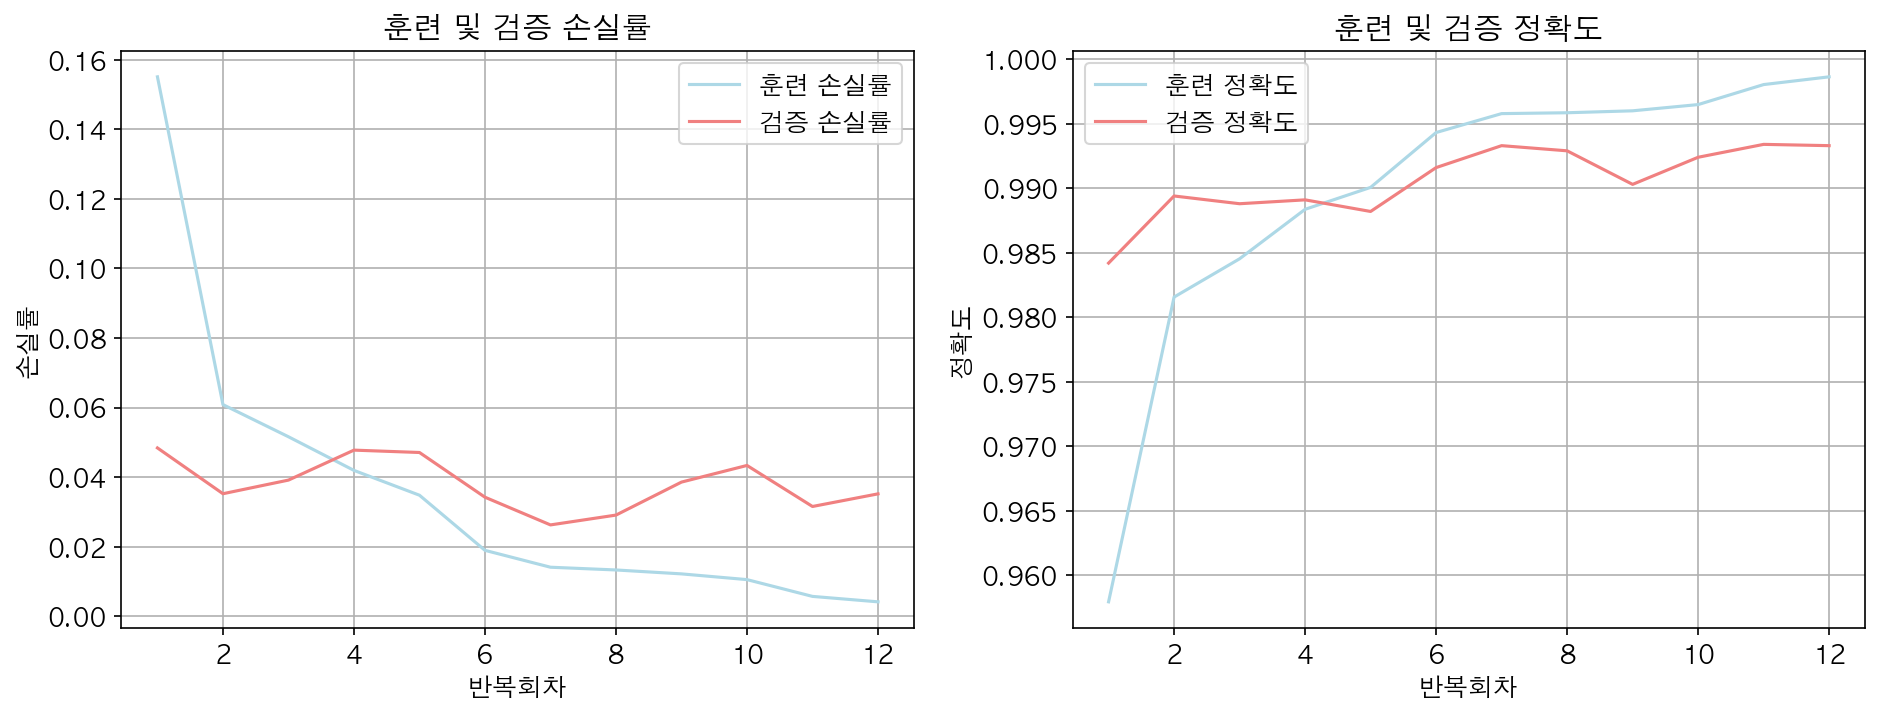

In [33]:
# 학습 결과 시각화

# 그래프 기본설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index,
            y='loss',
            data=result_df,
            color='lightblue',
            label='훈련 손실률',
            ax=ax1)
sb.lineplot(x=result_df.index, 
            y='val_loss',
            data=result_df,
            color='lightcoral',
            label='검증 손실률',
            ax = ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 정확도 그리기
sb.lineplot(x=result_df.index, 
            y='acc',
            data=result_df, 
            color='lightblue',
            label='훈련 정확도',
            ax=ax2)
sb.lineplot(x=result_df.index, 
            y='val_acc',
            data=result_df, 
            color='lightcoral',
            label='검증 정확도',
            ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [35]:
# 모델 성능 평가

evaluate1 = my_model.evaluate(x_train_reshape, y_train_one_hot)
print('최종 훈련 손실률: %f, 최종 훈련 절대오차: %f' % (evaluate1[0], evaluate1[1]))
evaluate2 = my_model.evaluate(x_test_reshape, y_test_one_hot)
print('최종 검증 손실률: %f, 최종 검증 절대오차: %f' % (evaluate2[0], evaluate2[1]))

1875/1875 [==============================] - 14s 8ms/step - loss: 6.3487e-04 - acc: 0.9998
최종 훈련 손실률: 0.000635, 최종 훈련 절대오차: 0.999800
313/313 [==============================] - 3s 9ms/step - loss: 0.0352 - acc: 0.9933
최종 검증 손실률: 0.035166, 최종 검증 절대오차: 0.993300


- 강사님 코드

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

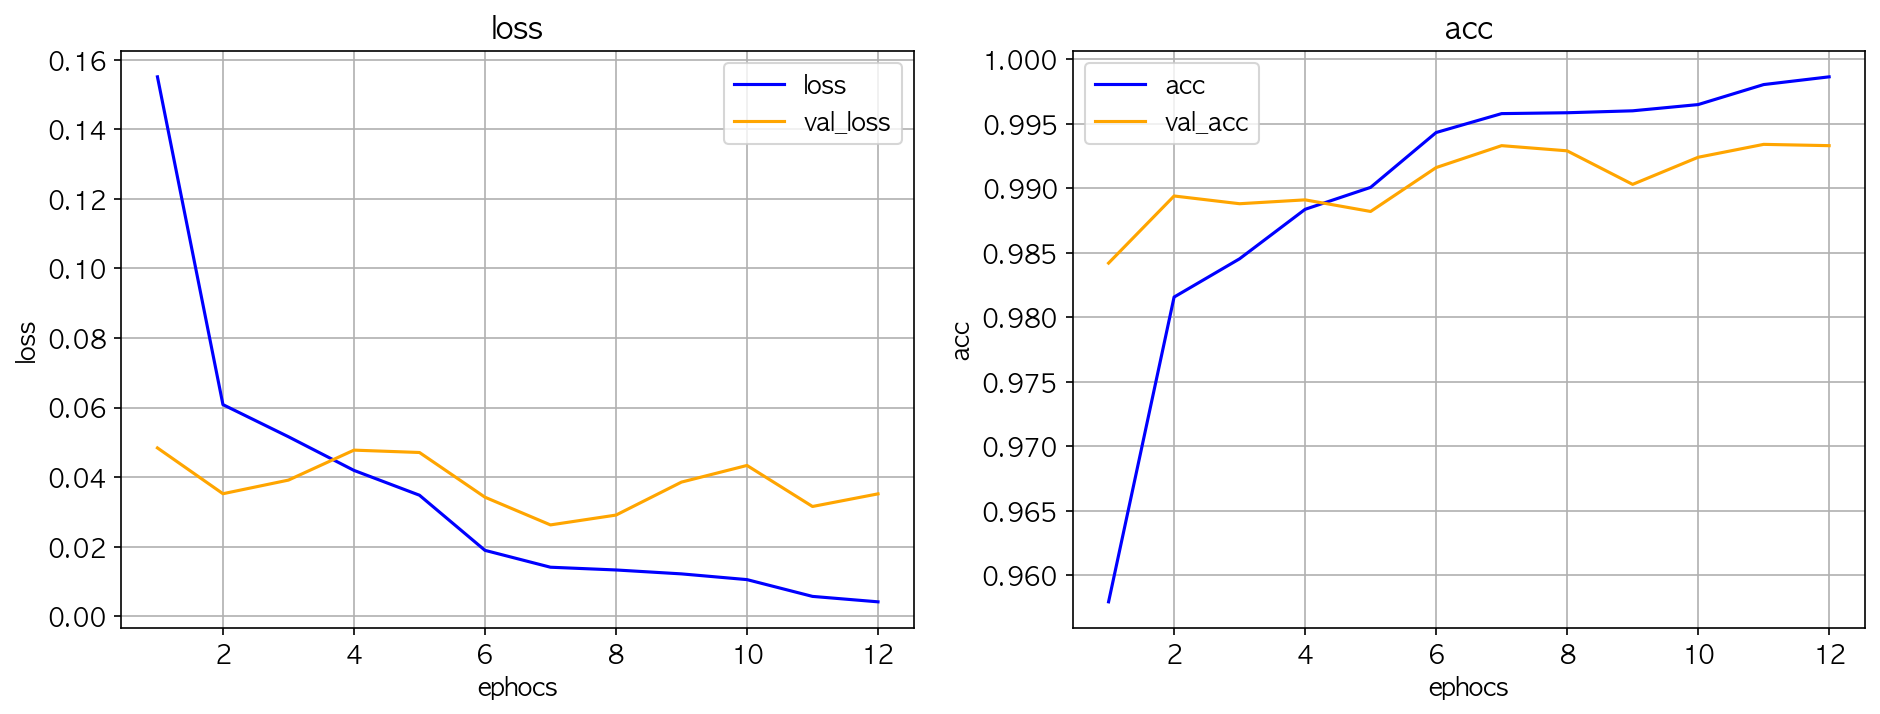

1875/1875 [==============================] - 15s 8ms/step - loss: 6.3487e-04 - acc: 0.9998
최종 훈련 손실률: 0.000635, 최종 훈련 정확도: 0.999800
313/313 [==============================] - 2s 8ms/step - loss: 0.0352 - acc: 0.9933
최종 검증 손실률: 0.035166, 최종 검증 정확도: 0.993300


In [36]:
helper.tf_result_plot(result)
evaluate1 = my_model.evaluate(x_train_reshape, y_train_one_hot)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = my_model.evaluate(x_test_reshape, y_test_one_hot)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

## 8. 학습 결과 적용
- 훈련 데이터에 대한 예측 결과 산정

In [40]:
result = my_model.predict(x_train_reshape)
data_count, case_count = result.shape
print('%d개의 검증 데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
result[0]

   1/1875 [..............................] - ETA: 50s

1875/1875 [==============================] - 15s 8ms/step
60000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([4.4343027e-18, 3.9296385e-18, 7.4720366e-18, 3.4398730e-07,
       5.0440662e-24, 9.9999964e-01, 2.5714859e-16, 2.1871888e-19,
       1.5607437e-13, 4.4605511e-13], dtype=float32)

- 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [42]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([5, 0, 4, ..., 5, 6, 8])

- 데이터 비교

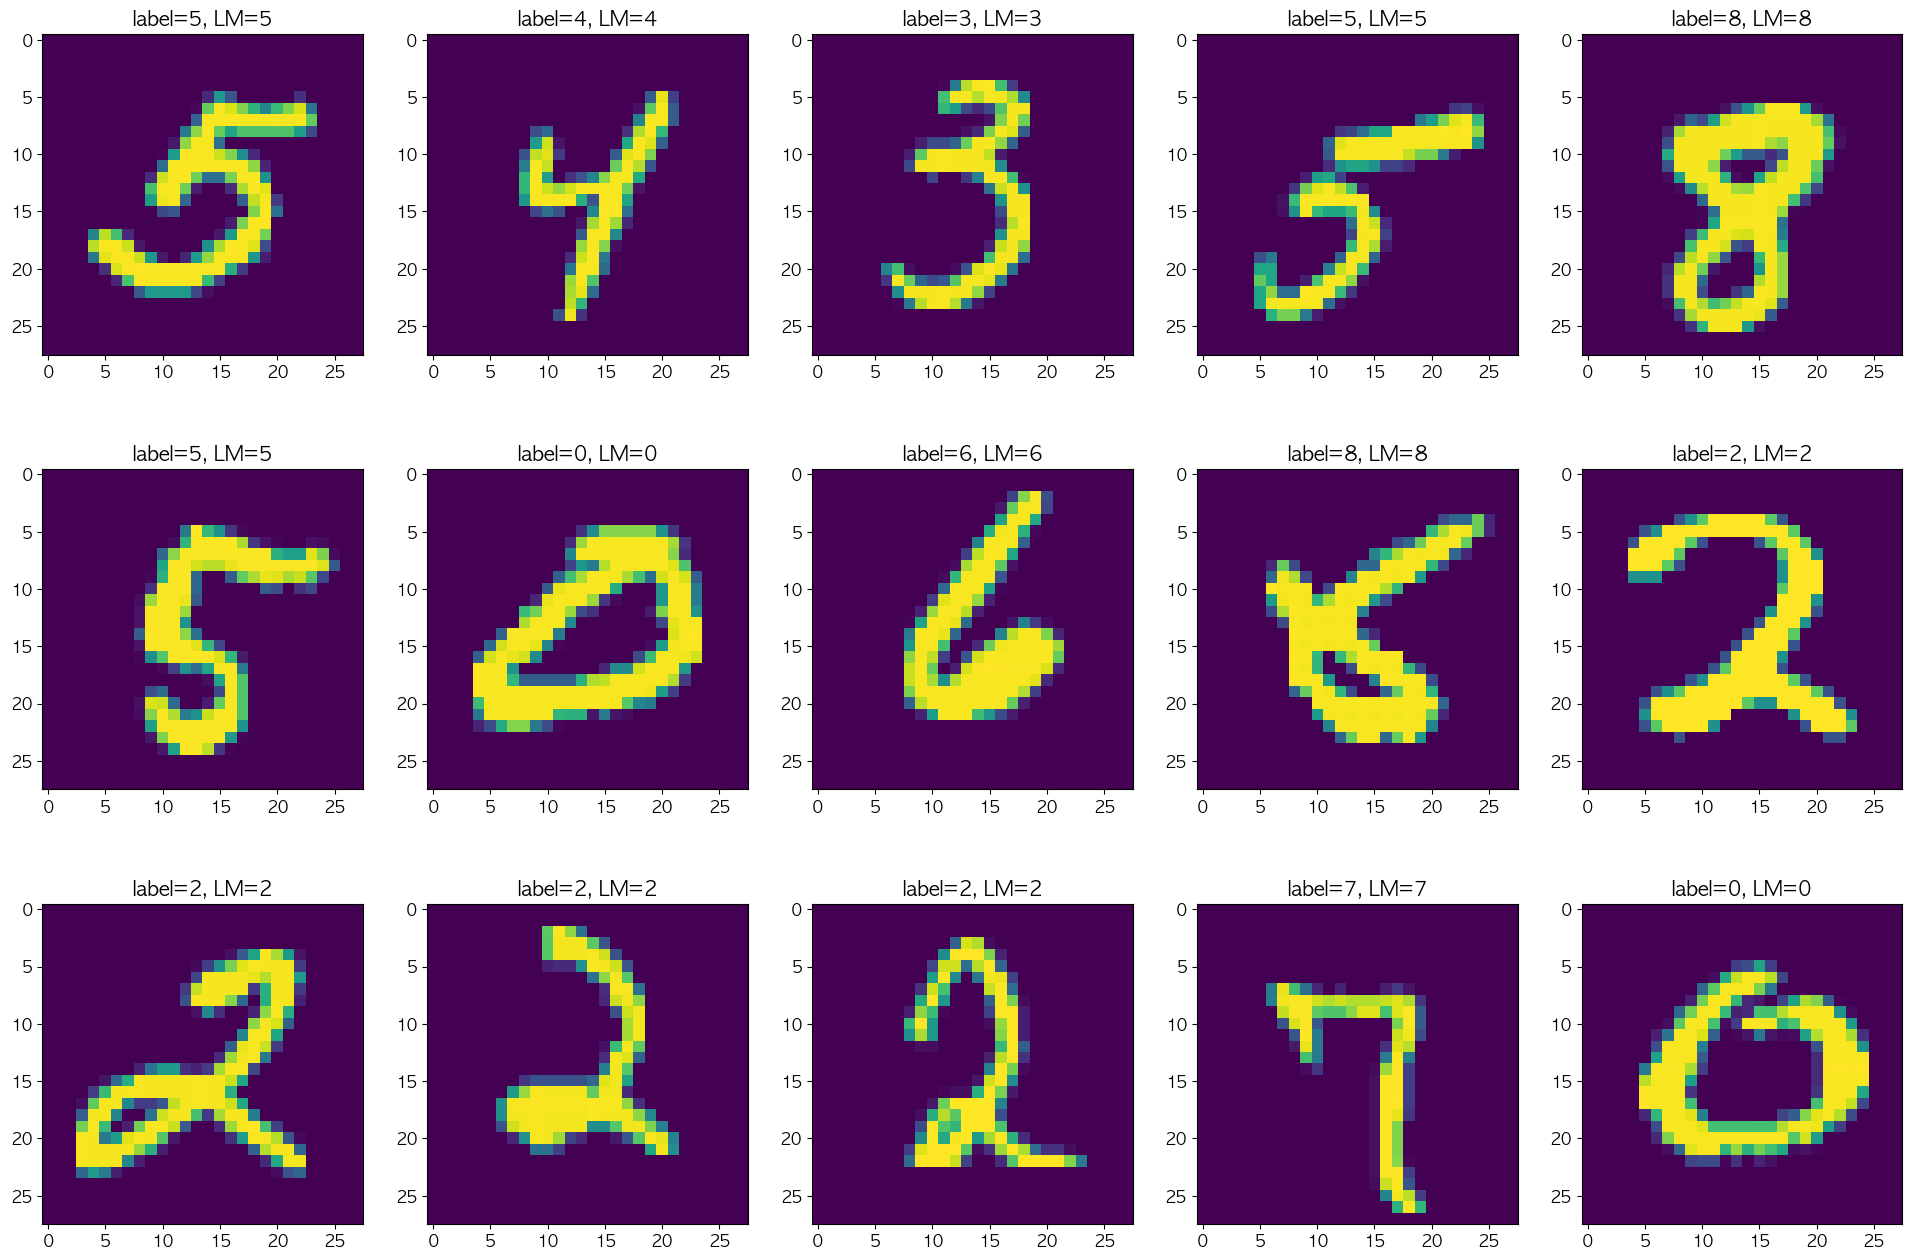

In [43]:
row = 3
col = 5
fig, ax = plt.subplots(row, 
                       col, 
                       figsize = ((col+1)*4,
                                  (row+1)*4),
                        dpi=100)
size = row*col
length = len(y_train)

for i in range(0, size):
    k = np.random.randint(length)
    train = x_train[k]
    label = y_train[k]
    ax[i//col][i%col].imshow(train)
    ax[i//col][i%col].set_title('label=%d, LM=%d' % (label, arg_result[k]))

plt.show()
plt.close()

- 혼돈행렬

In [44]:
cm = confusion_matrix(y_train, arg_result)
cmdf2 = DataFrame(cm, 
                  columns=list(map(lambda x: 'real(%d)' % x, range(10))),
                  index=list(map(lambda x: 'predict(%d)' % x,range(10))))
cmdf2

,real(0),real(1),real(2),real(3),real(4),real(5),real(6),real(7),real(8),real(9)
predict(0),5922,0,0,0,0,0,1,0,0,0
predict(1),0,6742,0,0,0,0,0,0,0,0
predict(2),0,0,5958,0,0,0,0,0,0,0
predict(3),0,0,0,6130,0,0,0,0,0,1
predict(4),0,1,0,0,5838,0,0,0,0,3
predict(5),0,0,0,0,0,5420,1,0,0,0
predict(6),0,0,0,0,0,0,5918,0,0,0
predict(7),0,2,0,0,0,0,0,6263,0,0
predict(8),0,1,0,0,0,0,0,0,5850,0
predict(9),0,0,0,0,1,0,0,1,0,5947


- 혼돈행렬 히트맵(시각화)

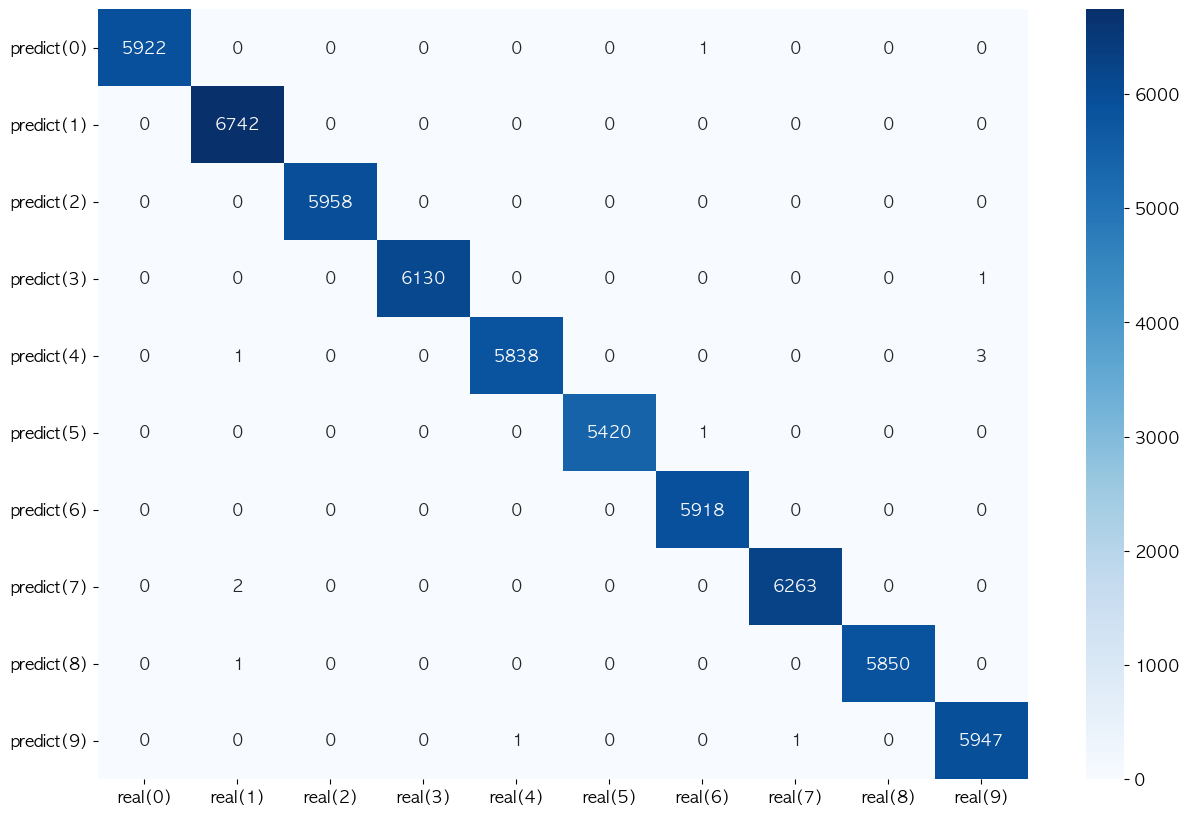

In [46]:
plt.figure(figsize=(15,10))
sb.heatmap(cmdf2, annot=True, fmt='d', cmap='Blues')
plt.show()
plt.close()